Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [3]:
NAME = "Bingyan Liu"

---

In [4]:
# Import packages and define common functions. Do not modify.
import os
import numpy as np
import random
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(img, file_name):
    """Show and save the image.
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.show()
    plt.imsave(f, npimg)

def train(model, train_loader, n_epochs=20, lr=0.01):
    """Train a generative model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data.view(-1, 784))
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

def train_vae2(model, train_loader, n_epochs=20, lr=0.01):
    """Train a generative model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data)
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# RBM

In [56]:
class RBM(nn.Module):
    """Restricted Boltzmann Machine.
    Args:
        n_vis (int, optional): The size of visible layer. Defaults to 784.
        n_hid (int, optional): The size of hidden layer. Defaults to 128.
        k (int, optional): The number of Gibbs sampling. Defaults to 1.
    """

    def __init__(self, n_vis=784, n_hid=128, k=1):
        """Create a RBM."""
        super(RBM, self).__init__()
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        r"""Conditional sampling a hidden variable given a visible variable.
        Args:
            v (Tensor): The visible variable.
        Returns:
            Tensor: The hidden variable.
        """
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        r"""Conditional sampling a visible variable given a hidden variable.
        Args:
            h (Tendor): The hidden variable.
        Returns:
            Tensor: The visible variable.
        """
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v, reduction='mean'):
        r"""Free energy function.
        .. math::
            \begin{align}
                F(x) &= -\log \sum_h \exp (-E(x, h)) \\
                &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
            \end{align}
        Args:
            v (Tensor): The visible variable.
        Returns:
            energy (FloatTensor): The free energy value.
        """
        v_term = torch.matmul(v, self.v.t())
        h_term = torch.sum(F.softplus(F.linear(v, self.W, self.h)), dim=-1, keepdim=True)
        energy = -v_term - h_term
        if reduction == 'none':
            return energy.squeeze(-1)
        elif reduction == 'mean':
            return torch.mean(energy)

    def forward(self, v):
        r"""Compute the real and generated examples.
        Args:
            v (Tensor): The visible variable.
        Returns:
            (Tensor, Tensor): The real and generagted variables.
        """
        for _ in range(self.k):
            h = self.visible_to_hidden(v)
            v_gibb = self.hidden_to_visible(h)
        return v, v_gibb
    
    def get_loss(self, inputs):
        r"""Compute the loss for training the model.
        Args:
            inputs (Tensor): The visible variable.
        Returns:
            Tensor: Loss.
        """
        v, v_gibb = self.forward(inputs)
        loss = self.free_energy(v) - self.free_energy(v_gibb)
        return loss
    
    @torch.no_grad()
    def pseudo_likelihood(self, v):
        """DO NOT MODIFY THIS FUNCTION"""
        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]), np.random.randint(0, v.shape[1], v.shape[0]))
        v_ = v.clone()
        v_[ind] = 1 - v_[ind]
        fe = self.free_energy(v, reduction='none')
        fe_ = self.free_energy(v_, reduction='none')
        m = torch.nn.LogSigmoid()
        score = v.shape[1] * m(fe_ - fe)
        return score


In [57]:
# DO NOT MODIFY
train_dataset = datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor(), lambda x: (x > 0).float()]
    )
)
test_dataset = datasets.MNIST('./data',
    train=False,
    transform = transforms.Compose(
        [transforms.ToTensor(), lambda x: (x > 0).float()]
    )
)

batch_size = 128
n_hid = 128
n_vis = 784
n_epochs = 20
lr = 0.01
rbm_ckpt_fn = 'model_rbm_seed2025.pt'

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [58]:
# You can try different k for the report, but use k=1 when submitting the checkpoint
# Do not modify other parts of this cell
if not os.path.exists(rbm_ckpt_fn):
    model_rbm = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
    model_rbm = train(model_rbm, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_rbm.state_dict(), rbm_ckpt_fn)


  5%|▌         | 1/20 [00:16<05:15, 16.59s/it]

Epoch 0	 Loss=104.6853


 10%|█         | 2/20 [00:38<05:57, 19.89s/it]

Epoch 1	 Loss=10.1086


 15%|█▌        | 3/20 [00:56<05:24, 19.10s/it]

Epoch 2	 Loss=2.9786


 20%|██        | 4/20 [01:14<04:55, 18.46s/it]

Epoch 3	 Loss=1.3378


 25%|██▌       | 5/20 [01:30<04:22, 17.49s/it]

Epoch 4	 Loss=0.9642


 30%|███       | 6/20 [01:46<03:57, 16.95s/it]

Epoch 5	 Loss=0.8963


 35%|███▌      | 7/20 [02:02<03:37, 16.72s/it]

Epoch 6	 Loss=0.9015


 40%|████      | 8/20 [02:19<03:23, 16.98s/it]

Epoch 7	 Loss=1.0414


 45%|████▌     | 9/20 [02:36<03:06, 16.99s/it]

Epoch 8	 Loss=1.1221


 50%|█████     | 10/20 [02:53<02:49, 16.96s/it]

Epoch 9	 Loss=1.0500


 55%|█████▌    | 11/20 [03:11<02:36, 17.34s/it]

Epoch 10	 Loss=1.0466


 60%|██████    | 12/20 [03:29<02:18, 17.26s/it]

Epoch 11	 Loss=1.0582


 65%|██████▌   | 13/20 [03:48<02:05, 17.97s/it]

Epoch 12	 Loss=1.2363


 70%|███████   | 14/20 [04:06<01:47, 17.86s/it]

Epoch 13	 Loss=1.2388


 75%|███████▌  | 15/20 [04:26<01:32, 18.55s/it]

Epoch 14	 Loss=1.3676


 80%|████████  | 16/20 [04:44<01:13, 18.26s/it]

Epoch 15	 Loss=1.3907


 85%|████████▌ | 17/20 [05:01<00:54, 18.08s/it]

Epoch 16	 Loss=1.5372


 90%|█████████ | 18/20 [05:19<00:36, 18.06s/it]

Epoch 17	 Loss=1.3267


 95%|█████████▌| 19/20 [05:38<00:18, 18.25s/it]

Epoch 18	 Loss=1.3995


100%|██████████| 20/20 [05:56<00:00, 17.84s/it]

Epoch 19	 Loss=1.4394


In [ ]:
# You can use the following code to visualize reconstructed samples
model_rbm.eval()
vis_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
images = next(iter(vis_loader))[0]
v, v_gibbs = model_rbm(images.view(-1, 784))
show_and_save(make_grid(v_gibbs.view(64, 1, 28, 28).data), 'rbm_fake')

# VAE

In [49]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        # Encoder
        self.enc_lin = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_sigma = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.dec_lin1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_lin2 = nn.Linear(hidden_dim, input_dim)

    
    def encoding(self, x):
        """Encode inputs x.
        Args:
            x (Tensor): Inputs. Take Tanh as the enc_lin layer's non-linear activation function.
        Returns:
            (z_mu, z_sigma): Mean and log variance of latent variables z.
        """
        x = torch.tanh(self.enc_lin(x))
        z_mu = self.enc_mu(x)
        z_sigma = self.enc_sigma(x)
        return z_mu, z_sigma
    
    def decoding(self, z):
        """Decode latent variable z into reconstructed data. 
        Two linear layers with Tanh as the middle layer's act func and Sigmoid as the output layer's act func.
        Args:
            z (Tensor): Inputs.
        Returns:
            x_hat: Reconstructed inputs. 
        """
        x = torch.tanh(self.dec_lin1(z))
        x_hat = torch.sigmoid(self.dec_lin2(x))
        return x_hat
    
    def forward(self, x):
        """Compute reconstructed inputs.
        Args:
            x (Tensor): Inputs.
        Returns:
            (x_hat, z_mu, z_sigma): Reconstructed inputs, mean and log variance of latent variables.
        """
        z_mu, z_sigma = self.encoding(x)
        std = torch.exp(0.5 * z_sigma)
        eps = torch.randn_like(std)
        z = z_mu + eps * std
        x_hat = self.decoding(z)
        
        
        return x_hat, z_mu, z_sigma
        
    def get_loss(self, x):
        """Compute VAE loss.
        Args:
            x (Tensor): Inputs.
        Returns:
            loss (FloatTensor): reconstruction loss + KL loss
        """
        x_hat, z_mu, z_sigma = self.forward(x)
        recon_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - z_sigma.exp())
        loss = recon_loss + kl_loss
        return loss
    
    @torch.no_grad()
    def sample(self, n_samples, device):
        random_z = torch.randn(n_samples, self.latent_dim).to(device)
        x_hat = self.decoding(random_z)
        return x_hat

In [50]:
# DO NOT MODIFY
train_dataset = datasets.MNIST('./data',
    train=True,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)
test_dataset = datasets.MNIST('./data',
    train=False,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)

batch_size = 128
input_dim = 784
hidden_dim = 500
n_epochs=40
lr=0.001
vae_ckpt_fn = 'model_vae_seed2025.pt'

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [51]:
# You can try different latent_dim for the report, but use latent_dim=20 when submitting the checkpoint
# Do not modify other parts of this cell
if not os.path.exists(vae_ckpt_fn):
    model_vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=20)
    model_vae = train(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_vae.state_dict(), vae_ckpt_fn)
    

  2%|▎         | 1/40 [00:15<10:19, 15.89s/it]

Epoch 0	 Loss=5755.6524


  5%|▌         | 2/40 [00:31<10:05, 15.93s/it]

Epoch 1	 Loss=4684.3877


  8%|▊         | 3/40 [00:46<09:30, 15.42s/it]

Epoch 2	 Loss=4537.5042


 10%|█         | 4/40 [01:03<09:31, 15.88s/it]

Epoch 3	 Loss=4403.6838


 12%|█▎        | 5/40 [01:19<09:23, 16.11s/it]

Epoch 4	 Loss=4272.7506


 15%|█▌        | 6/40 [01:35<09:02, 15.95s/it]

Epoch 5	 Loss=4176.5146


 18%|█▊        | 7/40 [01:52<08:58, 16.32s/it]

Epoch 6	 Loss=4113.8377


 20%|██        | 8/40 [02:08<08:37, 16.18s/it]

Epoch 7	 Loss=4059.3211


 22%|██▎       | 9/40 [02:23<08:13, 15.93s/it]

Epoch 8	 Loss=4020.1254


 25%|██▌       | 10/40 [02:39<07:52, 15.75s/it]

Epoch 9	 Loss=3986.0548


 28%|██▊       | 11/40 [02:56<07:51, 16.27s/it]

Epoch 10	 Loss=3959.0293


 30%|███       | 12/40 [03:13<07:39, 16.40s/it]

Epoch 11	 Loss=3934.2317


 32%|███▎      | 13/40 [03:29<07:25, 16.50s/it]

Epoch 12	 Loss=3917.6705


 35%|███▌      | 14/40 [03:45<07:04, 16.33s/it]

Epoch 13	 Loss=3900.5642


 38%|███▊      | 15/40 [04:00<06:36, 15.87s/it]

Epoch 14	 Loss=3891.3282


 40%|████      | 16/40 [04:15<06:10, 15.45s/it]

Epoch 15	 Loss=3874.7231


 42%|████▎     | 17/40 [04:30<05:55, 15.45s/it]

Epoch 16	 Loss=3857.9074


 45%|████▌     | 18/40 [04:46<05:42, 15.57s/it]

Epoch 17	 Loss=3845.7035


 48%|████▊     | 19/40 [05:02<05:27, 15.60s/it]

Epoch 18	 Loss=3841.6733


 50%|█████     | 20/40 [05:19<05:20, 16.03s/it]

Epoch 19	 Loss=3828.9133


 52%|█████▎    | 21/40 [05:36<05:10, 16.34s/it]

Epoch 20	 Loss=3822.3913


 55%|█████▌    | 22/40 [05:50<04:43, 15.77s/it]

Epoch 21	 Loss=3811.5778


 57%|█████▊    | 23/40 [06:05<04:22, 15.45s/it]

Epoch 22	 Loss=3803.8573


 60%|██████    | 24/40 [06:21<04:11, 15.72s/it]

Epoch 23	 Loss=3795.7865


 62%|██████▎   | 25/40 [06:37<03:55, 15.73s/it]

Epoch 24	 Loss=3792.3564


 65%|██████▌   | 26/40 [06:52<03:36, 15.47s/it]

Epoch 25	 Loss=3785.9890


 68%|██████▊   | 27/40 [07:08<03:23, 15.67s/it]

Epoch 26	 Loss=3783.3256


 70%|███████   | 28/40 [07:23<03:04, 15.37s/it]

Epoch 27	 Loss=3778.0752


 72%|███████▎  | 29/40 [07:39<02:50, 15.53s/it]

Epoch 28	 Loss=3771.4692


 75%|███████▌  | 30/40 [07:55<02:36, 15.70s/it]

Epoch 29	 Loss=3762.5171


 78%|███████▊  | 31/40 [08:09<02:18, 15.34s/it]

Epoch 30	 Loss=3759.0882


 80%|████████  | 32/40 [08:25<02:04, 15.62s/it]

Epoch 31	 Loss=3753.6795


 82%|████████▎ | 33/40 [08:44<01:54, 16.41s/it]

Epoch 32	 Loss=3750.3463


 85%|████████▌ | 34/40 [09:02<01:42, 17.14s/it]

Epoch 33	 Loss=3748.7993


 88%|████████▊ | 35/40 [09:18<01:22, 16.58s/it]

Epoch 34	 Loss=3743.3253


 90%|█████████ | 36/40 [09:31<01:02, 15.65s/it]

Epoch 35	 Loss=3737.0275


 92%|█████████▎| 37/40 [09:45<00:44, 14.97s/it]

Epoch 36	 Loss=3734.4802


 95%|█████████▌| 38/40 [09:59<00:29, 14.68s/it]

Epoch 37	 Loss=3737.4835


 98%|█████████▊| 39/40 [10:12<00:14, 14.26s/it]

Epoch 38	 Loss=3730.7863


100%|██████████| 40/40 [10:27<00:00, 15.69s/it]

Epoch 39	 Loss=3725.5977


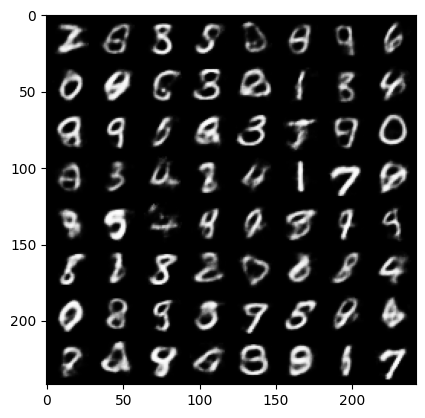

In [52]:
# You can use the following code to visualize generated samples
model_vae.eval()
x_hat = model_vae.sample(64, 'cpu')
# x_hat = x_hat.bernoulli()
show_and_save(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()), 'vae_fake')

# VAE2

In [53]:
class VAE2(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin_mu = nn.Linear(72, latent_dim)
        self.lin_logvar = nn.Linear(72, latent_dim)

        self.lin_decode = nn.Linear(latent_dim, 72)
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=2, stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3,padding=1)

    def encoding(self, x):
        """Encode inputs x.
        Args:
            x (Tensor): Inputs. Take Tanh as the enc_lin layer's non-linear activation function.
        Returns:
            (z_mu, z_sigma): Mean and log variance of latent variables z.
        """
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x_flat = x.view(x.size(0), -1)
        z_mu = self.lin_mu(x_flat)
        z_sigma = self.lin_logvar(x_flat)
        return z_mu, z_sigma
    
    def decoding(self, z):
        """Decode latent variable z into reconstructed data. 
        Two linear layers with Tanh as the middle layer's act func and Sigmoid as the output layer's act func.
        Args:
            z (Tensor): Inputs.
        Returns:
            x_hat: Reconstructed inputs. 
        """
        x_hat = self.lin_decode(z)
        x_hat = x_hat.view(x_hat.size(0), 8, 3, 3)
        x_hat = F.relu(self.deconv1(x_hat))
        x_hat = F.relu(self.deconv2(x_hat))
        x_hat = F.relu(self.deconv3(x_hat))
        x_hat = torch.sigmoid(self.conv(x_hat))
        return x_hat
    
    def forward(self, x):
        """Compute reconstructed inputs.
        Args:
            x (Tensor): Inputs.
        Returns:
            (x_hat, z_mu, z_sigma): Reconstructed inputs, mean and log variance of latent variables.
        """
        z_mu, z_sigma = self.encoding(x)
        std = torch.exp(0.5 * z_sigma)
        eps = torch.randn_like(std)
        z = z_mu + eps * std
        x_hat = self.decoding(z)
        return x_hat, z_mu, z_sigma
        
    def get_loss(self, x):
        """Compute VAE loss.
        Args:
            x (Tensor): Inputs.
        Returns:
            loss (FloatTensor): reconstruction loss + KL loss
        """
        x_hat, z_mu, z_sigma = self.forward(x)
        recon_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - z_sigma.exp())
        loss = recon_loss + kl_loss
        return loss
    
    @torch.no_grad()
    def sample(self, n_samples, device):
        random_z = torch.randn(n_samples, self.latent_dim).to(device)
        x_hat = self.decoding(random_z)
        return x_hat

In [54]:
# DO NOT MODIFY
train_dataset = datasets.MNIST('./data',
    train=True,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)
test_dataset = datasets.MNIST('./data',
    train=False,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)

batch_size = 128
n_epochs=40
lr=0.005
vae_ckpt_fn = 'model_vae2_seed2025.pt'

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

  2%|▎         | 1/40 [00:21<14:04, 21.64s/it]

Epoch 0	 Loss=7285.1346


  5%|▌         | 2/40 [00:43<13:43, 21.68s/it]

Epoch 1	 Loss=5414.3313


  8%|▊         | 3/40 [01:06<13:40, 22.17s/it]

Epoch 2	 Loss=4991.9675


 10%|█         | 4/40 [01:30<13:46, 22.95s/it]

Epoch 3	 Loss=4898.4314


 12%|█▎        | 5/40 [01:54<13:44, 23.56s/it]

Epoch 4	 Loss=4826.3054


 15%|█▌        | 6/40 [02:18<13:16, 23.42s/it]

Epoch 5	 Loss=4772.1739


 18%|█▊        | 7/40 [02:41<12:53, 23.43s/it]

Epoch 6	 Loss=4739.8994


 20%|██        | 8/40 [03:05<12:38, 23.71s/it]

Epoch 7	 Loss=4722.0483


 22%|██▎       | 9/40 [03:30<12:21, 23.93s/it]

Epoch 8	 Loss=4705.7677


 25%|██▌       | 10/40 [03:56<12:15, 24.53s/it]

Epoch 9	 Loss=4695.0416


 28%|██▊       | 11/40 [04:20<11:48, 24.43s/it]

Epoch 10	 Loss=4680.4884


 30%|███       | 12/40 [04:42<11:08, 23.88s/it]

Epoch 11	 Loss=4676.5204


 32%|███▎      | 13/40 [05:05<10:32, 23.41s/it]

Epoch 12	 Loss=4667.5213


 35%|███▌      | 14/40 [05:28<10:08, 23.40s/it]

Epoch 13	 Loss=4658.3307


 38%|███▊      | 15/40 [05:52<09:45, 23.42s/it]

Epoch 14	 Loss=4650.0772


 40%|████      | 16/40 [06:16<09:32, 23.84s/it]

Epoch 15	 Loss=4647.0181


 42%|████▎     | 17/40 [06:38<08:49, 23.03s/it]

Epoch 16	 Loss=4644.7843


 45%|████▌     | 18/40 [07:00<08:20, 22.75s/it]

Epoch 17	 Loss=4639.6862


 48%|████▊     | 19/40 [07:23<08:02, 22.99s/it]

Epoch 18	 Loss=4635.2720


 50%|█████     | 20/40 [07:46<07:40, 23.04s/it]

Epoch 19	 Loss=4630.2888


 52%|█████▎    | 21/40 [08:10<07:20, 23.16s/it]

Epoch 20	 Loss=4630.2634


 55%|█████▌    | 22/40 [08:35<07:06, 23.72s/it]

Epoch 21	 Loss=4627.8876


 57%|█████▊    | 23/40 [08:59<06:44, 23.80s/it]

Epoch 22	 Loss=4628.5768


 60%|██████    | 24/40 [09:21<06:12, 23.27s/it]

Epoch 23	 Loss=4621.9318


 62%|██████▎   | 25/40 [09:44<05:49, 23.33s/it]

Epoch 24	 Loss=4619.3841


 65%|██████▌   | 26/40 [10:09<05:33, 23.84s/it]

Epoch 25	 Loss=4609.7486


 68%|██████▊   | 27/40 [10:32<05:05, 23.51s/it]

Epoch 26	 Loss=4615.6629


 70%|███████   | 28/40 [10:53<04:34, 22.88s/it]

Epoch 27	 Loss=4613.4531


 72%|███████▎  | 29/40 [11:15<04:06, 22.39s/it]

Epoch 28	 Loss=4609.8761


 75%|███████▌  | 30/40 [11:36<03:41, 22.13s/it]

Epoch 29	 Loss=4605.4984


 78%|███████▊  | 31/40 [11:59<03:19, 22.20s/it]

Epoch 30	 Loss=4606.7047


 80%|████████  | 32/40 [12:20<02:56, 22.01s/it]

Epoch 31	 Loss=4603.3833


 82%|████████▎ | 33/40 [12:42<02:33, 21.89s/it]

Epoch 32	 Loss=4602.4518


 85%|████████▌ | 34/40 [13:03<02:10, 21.68s/it]

Epoch 33	 Loss=4597.5936


 88%|████████▊ | 35/40 [13:24<01:47, 21.46s/it]

Epoch 34	 Loss=4597.2228


 90%|█████████ | 36/40 [13:48<01:29, 22.30s/it]

Epoch 35	 Loss=4592.4413


 92%|█████████▎| 37/40 [14:11<01:07, 22.46s/it]

Epoch 36	 Loss=4590.0802


 95%|█████████▌| 38/40 [14:33<00:44, 22.32s/it]

Epoch 37	 Loss=4584.2156


 98%|█████████▊| 39/40 [14:56<00:22, 22.40s/it]

Epoch 38	 Loss=4587.3445


100%|██████████| 40/40 [15:19<00:00, 22.98s/it]

Epoch 39	 Loss=4582.8295


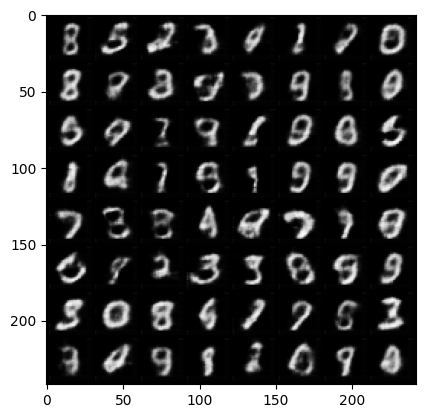

In [55]:
# You can try different latent_dim for the report, but use latent_dim=20 when submitting the checkpoint
# Do not modify other parts of this cell

if not os.path.exists(vae_ckpt_fn):
    model_vae2 = VAE2(latent_dim=20)
    model_vae2 = train_vae2(model_vae2, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_vae2.state_dict(), vae_ckpt_fn)
    
# You can use the following code to visualize generated samples
model_vae2.eval()
x_hat = model_vae2.sample(64, 'cpu')
# x_hat = x_hat.bernoulli()
show_and_save(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()), f'vae2_fake_{model_vae2.latent_dim}')